In [153]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

In [154]:
df_train = pd.read_csv('vowelformants_train.csv', names=['formant1', 'formant2', 'vowels'])
print(df_train.shape)
df_test = pd.read_csv('vowelformants_test.csv', names=['formant1', 'formant2', 'vowels'])
print(df_test.shape)

(2913, 3)
(324, 3)


In [155]:
x_train = np.array(df_train[['formant1', 'formant2']], dtype='float').reshape(-1,2)
labelEncoder = LabelEncoder()
labelEncoder.fit(df_train['vowels'])
y_train = labelEncoder.transform(np.array(df_train[['vowels']]).reshape(-1))
vowels = labelEncoder.classes_
index = labelEncoder.transform(labelEncoder.classes_)
index_to_vowel = dict(zip(index, vowels))
print(index_to_vowel)

{0: 'ah', 1: 'ao', 2: 'ax', 3: 'eh', 4: 'ey', 5: 'ih', 6: 'iy', 7: 'ow', 8: 'uw'}


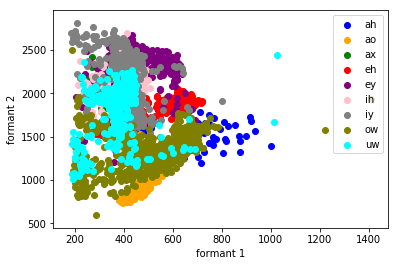

In [156]:
colors = ['blue', 'orange', 'green', 'red', 'purple', 'pink', 'gray', 'olive', 'cyan']
for i in index:
    plt.scatter(x_train[np.where(y_train==i), 0], x_train[np.where(y_train==i), 1], marker='o', c=colors[i])
    plt.xlabel('formant 1')
    plt.ylabel('formant 2')
    plt.legend(vowels)

**Part 1: From the above scatter plot, it can be seen that, for open vowel sound 'ah', the first formant has a higher frequency and close vowels such as 'uw' has a lower frequency for the first formant. On the other hand, the second formant has a higher frequency for front vowel sound 'iy' and a lower frequency for back vowel 'ow' or 'ao'.**

In [157]:
x_test = np.array(df_test[['formant1', 'formant2']], dtype='float').reshape(-1,2)
y_test = labelEncoder.transform(np.array(df_test[['vowels']]).reshape(-1))
x_test.shape

(324, 2)

In [158]:
class MyGaussianNB:
    def getLabelStats(self, X, y):
        self.labels, counts = np.unique(y, return_counts=True)
        self.label_freq = counts/len(y)
        label_dataset = [X[np.where(y==label)] for label in self.labels]
        return label_dataset

    def fit(self, X, y):
        label_X = self.getLabelStats(X, y)
        self.means = [np.mean(label_X[label], axis=0) for label in self.labels]
        self.stds = [np.std(label_X[label], axis=0) for label in self.labels]
        self.full_covs = [np.cov(label_X[label], rowvar = False) for label in self.labels]
        self.diag_covs = [self.full_covs[label]*np.identity(2) for label in self.labels]

    def get_gaussian_prob(self, x, mean, std):
        exponent = math.exp(-((x-mean)**2 / (2 * std**2)))
        return 1/(math.sqrt(2*math.pi)*std) * exponent

    def predict_proba(self, X):
        self.prob = [self.label_freq[label] for label in self.labels]
        for label in self.labels:
            for feature_idx in range(X.shape[-1]):
                self.prob[label] *= self.get_gaussian_prob(X[feature_idx], self.means[label][feature_idx], self.stds[label][feature_idx])
        return np.array(self.prob)

    def predict_wo_cov_mat(self, X):
        pred = []
        for x in X:
            label_prob = self.predict_proba(x)
            pred_label = np.unravel_index(label_prob.argmax(), label_prob.shape)[0]
            pred.append(pred_label)
        return np.array(pred)
    
    def predict(self, X, full_cov=False):
        if full_cov:
            probas = multivariate_normal(self.means[0], self.full_covs[0]).pdf(X) * self.label_freq[0]
            for k in range(1,len(self.labels)):
                t = multivariate_normal(self.means[k], self.full_covs[k]).pdf(X) * self.label_freq[k]
                probas = np.vstack((probas, t))
        else:
            probas = multivariate_normal(self.means[0], self.diag_covs[0]).pdf(X) * self.label_freq[0]
            for k in range(1,len(self.labels)):
                t = multivariate_normal(self.means[k], self.diag_covs[k]).pdf(X) * self.label_freq[k]
                probas = np.vstack((probas, t))

        return np.argmax(probas.T, axis=1)

In [159]:
mygnb = MyGaussianNB()
mygnb.fit(x_train, y_train)
y_pred = mygnb.predict_wo_cov_mat(x_test)
print("Accuracy without using cov_matrix(took product of 2 gaussian):",metrics.accuracy_score(y_test, y_pred))

y_pred = mygnb.predict(x_test)
print("Accuracy with diagoonal cov_matrix:",metrics.accuracy_score(y_test, y_pred))

y_pred = mygnb.predict(x_test, full_cov=True)
print("Accuracy with full cov_matrix:",metrics.accuracy_score(y_test, y_pred))

Accuracy without using cov_matrix(took product of 2 gaussian): 0.5617283950617284
Accuracy with diagoonal cov_matrix: 0.558641975308642
Accuracy with full cov_matrix: 0.595679012345679


In [160]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
print("Accuracy from sklearn:",metrics.accuracy_score(y_test, y_pred))

Accuracy from sklearn: 0.5617283950617284


**Part 2: A Gaussian Naive Bayes model has been developed which computes:**
$P(Vowel | Formants) = \frac{P(Formants | Vowel)*P(Vowel)}{P(Formants)} = \alpha P(Formants | Vowel)*P(Vowel) = \alpha P(Formant 1 | Vowel)*P(Formant 1 | Vowel)*P(Vowel)$
**Here, we make a naive assumption that each formant is conditionally independent, given the vowel.
The first accruacy is for a model where P(Formants | Vowel) is calculated simply multiplying two PDF score and the accuracy matches exactly with the that of sklearn's implementation.
Furthermore, the accuracy with full covariance matrix is higher than that with diagonal one. **

In [161]:
class GaussianMM:
    def __init__(self, n_clusters, full_cov=False, n_iters=1000, tol = 1e-4, seed = 4):
        self.n_clusters = n_clusters
        self.full_cov = full_cov
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_clusters))

        np.random.seed(self.seed)
        chosen = np.random.choice(n_row, self.n_clusters, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_clusters, 1 / self.n_clusters)
        
        shape = self.n_clusters, n_col, n_col
        if self.full_cov:
            self.covs = np.full(shape, np.cov(X, rowvar = False))
        else:
            self.covs = np.full(shape, np.cov(X, rowvar = False) * np.identity(2))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self.expectation(X)
            self.maximization(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)
        return self
    
    def getProbs(self, X):
        for k in range(self.n_clusters):
            prior = self.weights[k]
            try:
                likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            except:
                chosen = np.random.choice(X.shape[0], 1, replace = False)
                self.means[k] = X[chosen]
                self.covs[k] = np.cov(X, rowvar = False)
                likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood
        return self

    def expectation(self, X):
        self.getProbs(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def maximization(self, X):
        resp_weights = self.resp.sum(axis = 0)
        
        self.weights = resp_weights / X.shape[0]

        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        
        for k in range(self.n_clusters):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]           
        return self
    
    def predict(self, X):
        probas = multivariate_normal(self.means[0], self.covs[0]).pdf(X)
        for k in range(1,self.n_clusters):
            t = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            probas = np.vstack((probas, t))
        return np.argmax(probas.T, axis=1)

In [162]:
def identifyClusters(labels, pred):
    info = dict((k, dict((k, 0) for k in set(pred))) for k in set(labels))
    for i in range(len(labels)):
        info[labels[i]][pred[i]] += 1
    return info

def accuracy(info,mpv):
    correct = 0.0
    total = 0.0
    for i in info:
        for j in info[i]:
            total += info[i][j]
        correct += sum(sorted([info[i][k] for k in info[i]], reverse=True)[:mpv])

    return correct / total

In [163]:
mixtures_per_vowel = [1,2,3,4]
print("Diagonal Covariance:")
for mpv in mixtures_per_vowel:
    myGMM = GaussianMM(len(vowels)*mpv)
    myGMM.fit(features_train)
    y_pred = myGMM.predict(features_test)
    cluster_info = identifyClusters(y_test.tolist(), y_pred.tolist())
    acc = accuracy(cluster_info,mpv)
    print(f"Accuracy with {mpv} mixtures per vowel: {acc}")

Diagonal Covariance:
Accuracy with 1 mixtures per vowel: 0.5555555555555556
Accuracy with 2 mixtures per vowel: 0.6790123456790124
Accuracy with 3 mixtures per vowel: 0.6851851851851852
Accuracy with 4 mixtures per vowel: 0.6759259259259259


**Part 3: From above we see the test accuracy for 1, 2, 3, and 4 mixtures per vowel from EM algorithm. It shows that accuracy increases with the increase of mixtures per vowel until 4 where we see a decrease. It means 3 mixtures per vowel can estimate better.
In the corresponding bayesian network there will be 3 variables: V (vowel), F1 (Formant1), F2 (Formant2);
V being the parent of F1 and F2, there will be edge from V to both F1 and F2. F1 and F2 will have edge from one to the other as full covariance matrix does improve the accuracy.**

In [164]:
print("Full Covariance:")
for mpv in mixtures_per_vowel:
    myGMM = GaussianMM(len(vowels)*mpv, full_cov=True)
    myGMM.fit(features_train)
    y_pred = myGMM.predict(features_test)
    cluster_info = identifyClusters(y_test.tolist(), y_pred.tolist())
    acc = accuracy(cluster_info,mpv)
    print(f"Accuracy with {mpv} mixtures per vowel: {acc}")

Full Covariance:
Accuracy with 1 mixtures per vowel: 0.5555555555555556
Accuracy with 2 mixtures per vowel: 0.6882716049382716
Accuracy with 3 mixtures per vowel: 0.6975308641975309
Accuracy with 4 mixtures per vowel: 0.6327160493827161


**Bonus: In part 2, GuassianNB is modeled with full covariance gaussians as well, where we have seen a better accuracy (0.595679012345679) than the accuracy (0.558641975308642) of diagonal covariance one.
In part 3 also, we see for each value of mixtures per vowel except 4 has higer accuracy with full covariance than that of diagonal covariance.**